In [7]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import kwant.continuum
import dask.bag as db
from scipy.constants import electron_mass, hbar
import ccode.tools as tl
import ccode.solvers as sl
import scipy.sparse.linalg as sla
import time
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
import matplotlib as mpl

mpl.rcParams.update({'font.size': 16})

In [8]:
a = 10e-9

### Cluster configuration

In [9]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

## Calculation of topological phase in the nanowire sub bands

In [43]:
bare_wire_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu )*sigma_0
    + alpha * (k_x * sigma_y + k_y * sigma_x)
    + B_x * sigma_x
"""


def wire_parameters(m, bx):
    a = 10e-9
    t = hbar ** 2 / (2 * 0.023 * electron_mass) * (6.24e18)
    alpha = 0.3e-10
    parameters = dict(mu=(m), t=t, alpha=alpha, B_x=bx, a=a)
    return parameters


In [44]:
params_wire = wire_parameters(m=0, bx=0)
wire_width = 7*a

In [45]:
template_bare = kwant.continuum.discretize(bare_wire_hamiltonian, grid=a)
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-a, 0]))
w_nw = wire_width
lead.fill(template_bare, shape=lambda site: 0 <= site.pos[1] < w_nw, start=[0]);

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


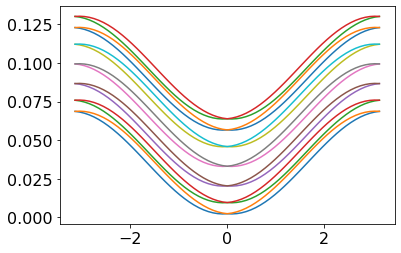

In [46]:
fig, ax = plt.subplots()
kwant.plotter.bands(lead.finalized(), show=False, params=params_wire, ax=ax)
plt.show()

In [47]:
bands = []
data = []
for line in ax.lines:
    band_data = line.get_data()
    data.append(band_data)
    len_band = len(band_data[1])
    effective_mu = band_data[1][len_band // 2]
    bands.append(effective_mu)

bands = bands[:-1:2]
bands = np.array(bands)
data = np.array(data)

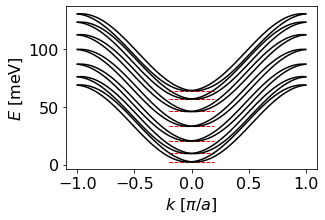

In [51]:
fig, ax = plt.subplots(figsize=(4.5, 3))
for band in data:
    ax.plot(band[0]/np.pi, 1e3*band[1], c='black')
ax.hlines(y=1e3*bands, xmin=-.2, xmax=.2, color='red', linewidth=1, linestyle='dashed')
ax.set_xlabel(r'$k$ [$\pi/a$]')
ax.set_ylabel(r'$E$ [meV]')
plt.savefig('../data/sub_bands.pdf')

In [12]:
def topological_field(Delta, mu_shift):
    topo_B = np.sqrt(Delta**2 + (mu_shift-2*params['t']/(a**2))**2)
    return topo_B

toological_field = np.vectorize(topological_field)

### Finite system

In [13]:
hamiltonian = """( t * (k_x**2 + k_y**2 ) - mu_nw )* kron(sigma_0, sigma_z)
+ alpha * k_x * kron(sigma_y, sigma_z)
- alpha * k_y * kron(sigma_x, sigma_z)
+ Delta * kron(sigma_0, sigma_x)
+ B_x * kron(sigma_x, sigma_0)"""

template = kwant.continuum.discretize(hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [14]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_wire(**params):
    wire = kwant.Builder()
    wire.fill(template, shape=interval_shape(params['L'], params['W']), start=[0])
    return wire.finalized()


def junction_parameters(m_nw, bx):
    """
    Typical parameters
    """

    a = 10E-9
    t = hbar**2/(2*0.023*electron_mass)*(6.24E18)
    alpha = 0.3E-10
    Delta = 5E-4
    parameters = dict(mu_nw=m_nw,
                      t=t,
                      Delta=Delta,
                      alpha=alpha,
                      B_x=bx,
                      phi1=0,
                      phi2=0,
                      a=a)
    return parameters


def simple_solver(geometries, n, key, eigenvecs=False):
    """
    Return a function that diagonalizes the Hamiltonian for different geometries.
    The parameters for the Hamiltonian are set from the beginning, and only one
    parameter is varied via key and mu.
    """
    def eigensystem_sla(geometry_index, mu, params):

        system, params_func = geometries[geometry_index]

        params[key] = mu

        ham_mat = system.hamiltonian_submatrix(sparse=True, params=params_func(**params))

        if not eigenvecs:
            evals = np.sort(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs))
            evecs = []
        else:
            evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))

        return evals, evecs

    return eigensystem_sla

In [15]:
geometry_single_wire = {"L": 120*a, "W": wire_width}
wire = make_wire(**geometry_single_wire)


def identity(**arg):
    return arg

In [16]:
Bs = np.linspace(0.00, 0.002, 200)
key = 'B_x'
n = 40
eigen_single_wire = simple_solver(geometries=[[wire, identity]], n=n, key=key)


def wrapper(arg):
    return eigen_single_wire(*arg)

In [17]:
extra_params = junction_parameters(m_nw=bands[0], bx=0)
args = list(it.product([0], Bs, [extra_params]))
args_db = db.from_sequence(args, npartitions=20)

In [18]:
ens = []
wfs = []

for arg in args:
    e, v = wrapper(arg)
    ens.append(e)
    wfs.append(v)

ens = np.array(ens)
wfs = np.array(wfs)

In [45]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])
    result = args_db.map(wrapper).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/cd33947ab1e74b498cc32d3cbc8c259b/status


In [46]:
ens, wfs = tl.separate_energies_wfs(result)

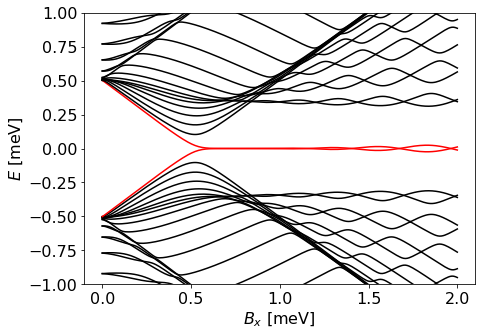

In [22]:
colors = ['black']*(int(n/2)-1)
colors.append('red')
colors += colors[::-1]

fig, ax = plt.subplots(figsize=(7, 5))
i = 0
for level in ens.T:
    ax.plot(1e3*Bs, 1e3*level, c=colors[i])
    i += 1
ax.set_ylim(-1, 1)
ax.set_xlabel(r'$B_x$ [meV]')
ax.set_ylabel(r'$E$ [meV]')
plt.savefig('../data/phase_transition.pdf')

In [ ]:
eigen_single_wire = simple_solver(geometries=[[wire, identity]], n=6, key=key, eigenvecs=True)


def wrapper(arg):
    return eigen_single_wire(*arg)

In [ ]:
%%time
evecs = []
for i in range(7):
    en, evec = wrapper([0, 0.6e-3, junction_parameters(m_nw=bands[i], bx=0.6e-3)])
    evecs.append(evec)

CPU times: user 1.03 s, sys: 8.03 ms, total: 1.04 s
Wall time: 1.04 s


In [23]:
density = kwant.operator.Density(wire, np.eye(4))

/tmp/ipykernel_596/1019029875.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(evecs[i][3]), ax=axes)
/tmp/ipykernel_596/1019029875.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(evecs[i][3]), ax=axes)
/tmp/ipykernel_596/1019029875.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object'

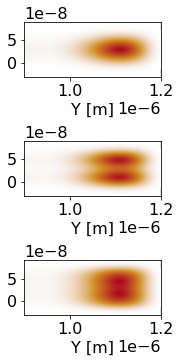

In [40]:
fig, ax = plt.subplots(nrows=3, figsize=(3, 5))
fig.tight_layout(h_pad=2)
i = 0
for axes in ax.flatten():
    kwant.plotter.density(wire, density(evecs[i][3]), ax=axes)
    axes.set_xlim(0.9e-6, 1.2e-6)
    #axes.set_ylabel(r'X [m]')
    axes.set_xlabel(r'Y [m]')
    i+=1
plt.savefig('../data/majorana_wfs_R.pdf')

In [ ]:
def junction_parameters(m_nw, m_qd, bx):
    """
    Typical parameters
    """

    a = 10E-9
    t = hbar**2/(2*0.023*electron_mass)*(6.24E18)
    alpha = 0.3E-10
    Delta = 5E-4
    parameters = dict(mus_nw=m_nw,
                      mu_qd=m_qd,
                      t=t,
                      Delta=Delta,
                      alpha=alpha,
                      B_x=bx,
                      phi1=0,
                      phi2=0,
                      a=a)
    return parameters

In [ ]:
params = junction_parameters(m_nw=0, m_qd=0, bx=0)

In [9]:
def wrap(args):
    return eigen_single_wire(*args)


def identity(**arg):
    return arg

In [44]:
parameters = []
for mu in bands:
    p = params.copy()
    p.update(mu_nw=mu)
    parameters.append(p)

In [45]:
%%time
args_sw = list(it.product([[wire, identity]], Bs, parameters))
db_args_sw = db.from_sequence(args_sw, npartitions=20)
result_sw = db_args_sw.map(wrap).compute()
en, wf = tl.separate_energies_wfs(result_sw)

CPU times: user 1.01 s, sys: 158 ms, total: 1.17 s
Wall time: 21.6 s


In [46]:
energies_bs = [[] for i in range(len(bands))]
for i in range(len(bands)*len(Bs)):
    energies_bs[i%len(bands)].append(en[i])
energies_bs = np.array(energies_bs)

In [47]:
Delta = params['Delta']
fields = topological_field(Delta=Delta, mu_shift=np.array(bands))

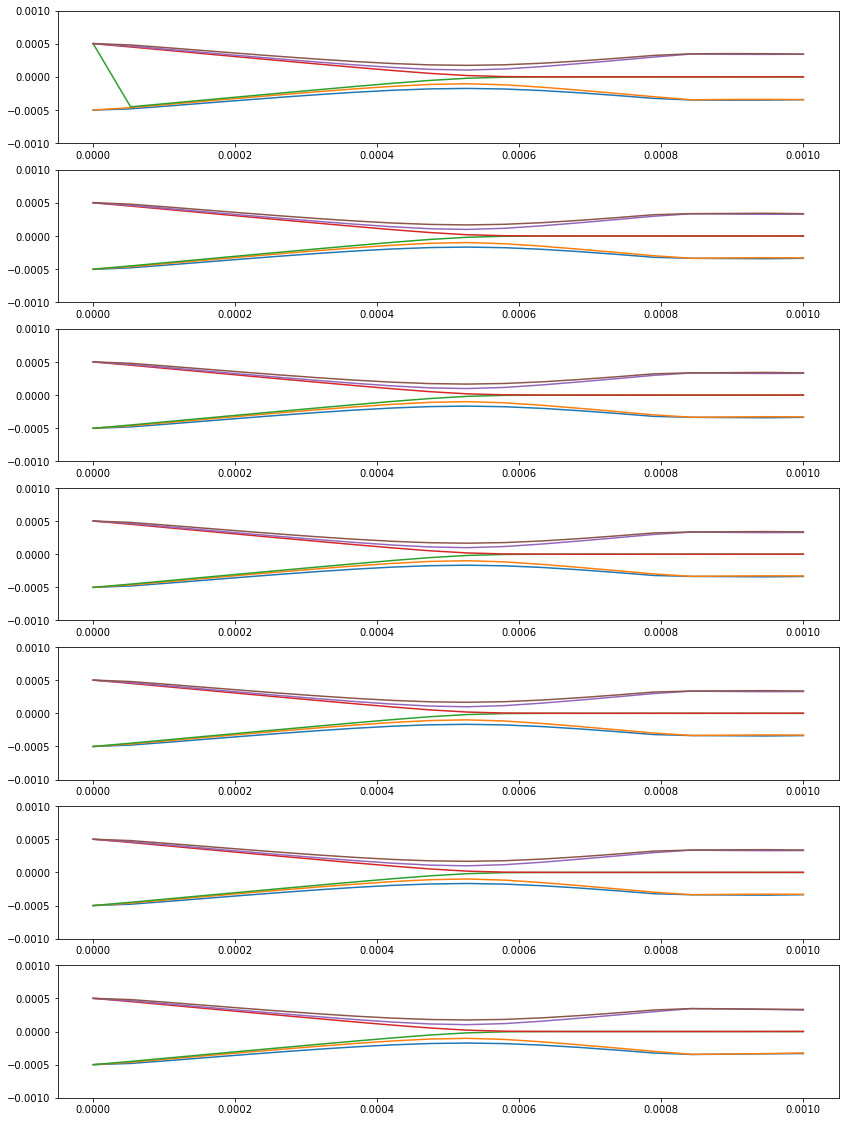

In [48]:
fig, axes = plt.subplots(ncols=1, nrows=len(bands), figsize=(14, 20))
i = 0
colors = ['black' for i in range(len(bands))]
colors[n//2] = 'red'
colors[n//2-1] = 'red'
for ax in axes:
    ax.plot(Bs, energies_bs[i])
    ax.set_ylim(-0.001, 0.001)
#    ax.vlines(x=fields[i], ymin=-1, ymax=1)
    i += 1

In [56]:
vals = []
vecs = []
for i in range(len(bands)):
    params.update(mu_nw = bands[i])
    params.update(B_x = 0.001)
    ham = wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = tl.sort_eigen(sla.eigsh(ham, k=2, sigma=0))
    vals.append(val)
    vecs.append(vec)

In [57]:
density = kwant.operator.Density(wire, np.eye(4))

/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' 

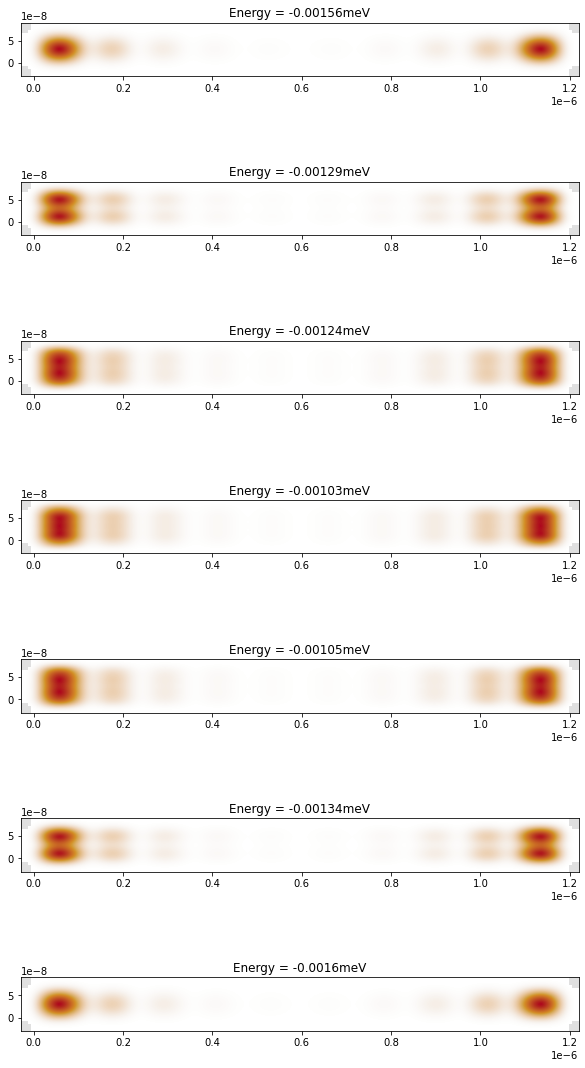

In [58]:
fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(10, 20))
i = 0
for ax in axes.flatten():
    kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
    ax.set_title('Energy = '+str(np.round(vals[i][0]*1000, 5))+'meV')
    i += 1

In [52]:
bands

[0.0023960204649275973,
 0.009605416498312178,
 0.020395040147213304,
 0.03312226901926766,
 0.045849497891322026,
 0.056639121540223145,
 0.06384851757360771]